In [1]:
import pandas as pd
import numpy as np
import pickle
import json
import os

## Analysis: Test, Dev, Train Set. 

In [2]:
#read the title of the accepted papers and store it in a list so that we can compare the shits later
#acceptedACL = []
fp = open('data/acl2017/acl_accepted.txt', 'r', encoding='utf-8')
acceptedACL = [line.rstrip('\n') for line in fp]

In [50]:
#lets read the train folder from 
loc = "/data/acl2017/train/parsed_pdfs"
acceptCount = 0
rejectCount = 0
totalTrainPapers = 0

for filename in os.listdir(os.getcwd()+loc):
    totalTrainPapers+=1
    #with open(os.path.join(os.getcwd()+loc, filename), 'r') as json_data:
    data = json.load(open(os.path.join(os.getcwd()+loc, filename), 'r', encoding='utf-8'))
    #s = str(data['metadata']['title']).replace(" ", "")
    #print(data['metadata']['title'])
    if data['metadata']['title'] in acceptedACL:
        acceptCount+=1
    else:
        rejectCount+=1
    
    if totalTrainPapers == 2:
        break;
print("TOtal Papers = {}, Train Set Accepted Papers = {}, Train Set Rejected Papers = {}".format(totalTrainPapers,acceptCount, rejectCount))

TOtal Papers = 2, Train Set Accepted Papers = 1, Train Set Rejected Papers = 1


In [99]:
#lets read the dev folder from 
loc = "/data/acl2017/dev/parsed_pdfs"
acceptCount = 0
rejectCount = 0
totalDevPapers = 0
for filename in os.listdir(os.getcwd()+loc):
    totalDevPapers+=1
    #with open(os.path.join(os.getcwd()+loc, filename), 'r') as json_data:
    data = json.load(open(os.path.join(os.getcwd()+loc, filename), 'r', encoding='utf-8'))
    #s = str(data['metadata']['title']).replace(" ", "")
    #print(data['metadata']['title'])
    if data['metadata']['title'] in acceptedACL:
        acceptCount+=1
    else:
        rejectCount+=1
print("TOtal Dev Papers = {}, Dev Set Accepted Papers = {}, Dev Set Rejected Papers = {}".format(totalDevPapers,acceptCount, rejectCount))

TOtal Dev Papers = 7, Dev Set Accepted Papers = 2, Dev Set Rejected Papers = 5


In [98]:
#lets read the test folder from 
loc = "/data/acl2017/test/parsed_pdfs"
acceptCount = 0
rejectCount = 0
totalTestPapers = 0
for filename in os.listdir(os.getcwd()+loc):
    totalTestPapers+=1
    #with open(os.path.join(os.getcwd()+loc, filename), 'r') as json_data:
    data = json.load(open(os.path.join(os.getcwd()+loc, filename), 'r', encoding='utf-8'))
    #s = str(data['metadata']['title']).replace(" ", "")
    #print(data['metadata']['title'])
    if data['metadata']['title'] in acceptedACL:
        acceptCount+=1
    else:
        rejectCount+=1
print("TOtal Test Papers = {}, Test Set Accepted Papers = {}, Test Set Rejected Papers = {}".format(totalTestPapers,acceptCount, rejectCount))

TOtal Test Papers = 7, Test Set Accepted Papers = 4, Test Set Rejected Papers = 3


## Prepare The Train Set and featurize
We define train set in our case as = Train Set + Dev Set
**Note**: Author info will be dropped as no author info is available in the dataset. Privacy?? Maybe



In [66]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [72]:
def avg_abs_sent_length(abstract):
    avg_sent_length = 0
    
    doc = nlp(abstract)
    for s in doc.sents:
        avg_sent_length += len(s)
    
    num_sents = len(list(doc.sents))
    
    if num_sents > 0:
        return avg_sent_length/num_sents
    else:
        return avg_sent_length
    
def sota_present(abstract):
    if abstract.lower().find('state-of-the-art') > -1 or abstract.lower().find('state of the art') > -1:
            return 1
    return 0

def ml_keywords_present(abstract):
    # collected from sense2vec spacy
    ml_keywords = ["outperforms", "outperform", "novel", "machine learning", "deep learning", "neural nets", "neural networks", "rnns", "rnn", "cnn", "cnns", "attention", "lstm", "adversarial network"]
    for keyw in ml_keywords:
        if abstract.lower().find(keyw) > -1:
            return 1
    return 0

In [79]:
embeddings_dict = {}

with open("data/glove.6B/glove.6B.300d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [80]:
def get_glove_avg(abstract):
    glove_avg = 0
    count = 0
    
    doc = nlp(abstract)
    
    for tok in doc:
        if not tok.is_stop:
            clean_token = tok.text.lower().strip()
            if clean_token in embeddings_dict:
                count += 1
                glove_avg += embeddings_dict[clean_token]
    
    if count > 1:
        return np.mean(glove_avg/count)
    else:
        return np.mean(glove_avg)

In [100]:
#lets read the train folder from 
loc = "/data/acl2017/train/parsed_pdfs"
i=0
d = []
keyword = ['deep', 'neural', 'embedding', 'outperform', 'outperform', 'novel', 'state of the art']


for filename in os.listdir(os.getcwd()+loc):
    i+=1
    item = json.load(open(os.path.join(os.getcwd()+loc, filename), 'r', encoding='utf-8'))
    
    if len(str(item['metadata']['title']).split()) == 0:
        continue
    

    d.append(
        {
            'glove_abstract': get_glove_avg(str(item['metadata']['abstractText'])),
            'n_title_word': len(str(item['metadata']['title']).split()),
            'n_title_char': len(str(item['metadata']['title']).replace(" ", "")),
            'n_abstract_word': len(str(item['metadata']['abstractText']).split()),
            'n_abstract_char': len(str(item['metadata']['abstractText']).replace(" ","")),
            'n_sections': len(item['metadata']['sections']),
            'n_references': len(item['metadata']['references']),
            'most_recent_refs_year': max([item['year'] for item in data['metadata']['references']]),
            'avg_sentence_length': avg_abs_sent_length(str(item['metadata']['abstractText'])),
            'abstract_contains_sota': sota_present(str(item['metadata']['abstractText'])),
            'abstract_contains_mlkeyword':ml_keywords_present(str(item['metadata']['abstractText'])),
            'label': 'Accept' if item['metadata']['title'] in acceptedACL else 'Reject'
        }
    )

#lets use the dev folder data as train data too
loc = "/data/acl2017/dev/parsed_pdfs"

for filename in os.listdir(os.getcwd()+loc):
    i+=1
    item = json.load(open(os.path.join(os.getcwd()+loc, filename), 'r', encoding='utf-8'))
    
    if len(str(item['metadata']['title']).split()) == 0:
        continue

    d.append(
        {
            'glove_abstract': get_glove_avg(str(item['metadata']['abstractText'])),
            'n_title_word': len(str(item['metadata']['title']).split()),
            'n_title_char': len(str(item['metadata']['title']).replace(" ", "")),
            'n_abstract_word': len(str(item['metadata']['abstractText']).split()),
            'n_abstract_char': len(str(item['metadata']['abstractText']).replace(" ","")),
            'n_sections': len(item['metadata']['sections']),
            'n_references': len(item['metadata']['references']),
            'most_recent_refs_year': max([item['year'] for item in data['metadata']['references']]),
            'avg_sentence_length': avg_abs_sent_length(str(item['metadata']['abstractText'])),
            'abstract_contains_sota': sota_present(str(item['metadata']['abstractText'])),
            'abstract_contains_mlkeyword':ml_keywords_present(str(item['metadata']['abstractText'])),
            'label': 'Accept' if item['metadata']['title'] in acceptedACL else 'Reject'
        }
    )


In [101]:
trainData = pd.DataFrame(d)

In [102]:
trainData.shape

(130, 12)

In [103]:
trainData

,glove_abstract,n_title_word,n_title_char,n_abstract_word,n_abstract_char,n_sections,n_references,most_recent_refs_year,avg_sentence_length,abstract_contains_sota,abstract_contains_mlkeyword,label
0,-0.001345,1,4,142,834,1,46,2016,28.333333,1,1,Reject
1,0.002408,7,59,100,566,11,36,2016,37.000000,1,1,Accept
2,0.002873,12,100,192,1076,19,0,2016,30.125000,1,1,Accept
3,-0.001667,7,53,92,554,20,21,2016,25.500000,0,1,Reject
4,-0.000885,9,64,111,708,42,30,2016,22.666667,1,1,Accept
...,...,...,...,...,...,...,...,...,...,...,...,...
125,0.000984,13,97,140,827,18,34,2016,23.285714,1,1,Reject
126,0.002963,1,4,161,940,18,41,2016,28.714286,1,1,Reject
127,-0.004748,15,112,167,958,17,33,2016,31.166667,0,0,Reject
128,-0.004481,7,54,148,834,10,30,2016,23.428571,0,1,Accept


In [104]:
# shuffle the data
trainData = trainData.sample(n=len(trainData), random_state=42)

In [105]:
# To plot the Decision Tree--------------------------------------------
def plot(clf):
  dot_data = StringIO()
  tree.export_graphviz(clf[0], 
  out_file=dot_data, 
  class_names=['Accept','Reject'], # the target names.
  feature_names=X.columns, # the feature names.
  filled=True, # Whether to fill in the boxes with colours.
  rounded=True, # Whether to round the corners of the boxes.
  special_characters=True)
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
  return Image(graph.create_png())

## Modeling

In [106]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
# Models-------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process.kernels as kls
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# for visualizing ---------------
import pydotplus
from sklearn import tree
from sklearn.externals.six import StringIO 
from IPython.display import Image, display
import seaborn as sns
# General purpose
import re
import warnings
warnings.filterwarnings('ignore')

In [107]:
clf_dict = {'DecisionTree':DecisionTreeClassifier(max_depth=2),
            'RandomForest':RandomForestClassifier(max_depth=10),
            'LogisticR':LogisticRegression(max_iter=5000),
            'LogisticLassoR':LogisticRegression(max_iter=5000, penalty='l1',solver='liblinear'),
            'RidgeClf':RidgeClassifier(max_iter=5000),
            'SVC':SVC(kernel='rbf'),
            'GaussNB':GaussianNB(),
            'NeuralNet':MLPClassifier((50),activation='logistic'),
            'KNN':KNeighborsClassifier(n_neighbors=10),
            'GaussianProcessClf':GaussianProcessClassifier(kernel=kls.RBF())
            }

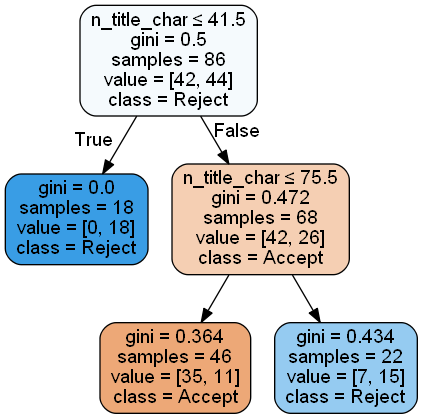

In [108]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
    X = trainData.drop(columns=['label'])
    y = trainData['label']
    results = cross_validate(clf, X, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == 'DecisionTree':
        display(plot(clf))

In [109]:
model_results

,Accuracy,CVresults
DecisionTree,0.692741,"{'fit_time': [0.0029892921447753906, 0.0029911..."
RandomForest,0.669486,"{'fit_time': [0.009977102279663086, 0.00794196..."
LogisticR,0.652748,"{'fit_time': [0.0020303726196289062, 0.0030517..."
LogisticLassoR,0.652925,"{'fit_time': [0.007016658782958984, 0.00997281..."
RidgeClf,0.652748,"{'fit_time': [0.0049974918365478516, 0.0029890..."
SVC,0.507752,"{'fit_time': [0.0019888877868652344, 0.0020341..."
GaussNB,0.637949,"{'fit_time': [0.001993894577026367, 0.00323343..."
NeuralNet,0.707717,"{'fit_time': [0.0891571044921875, 0.0937025547..."
KNN,0.592495,"{'fit_time': [0.002979278564453125, 0.00199484..."
GaussianProcessClf,0.607118,"{'fit_time': [0.006015777587890625, 0.00698089..."


In [181]:
# Copy the results into .md file to visualize the table in .md
model_results.drop(columns=['CVresults']).to_html().replace('\n','')

'<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>Accuracy</th>    </tr>  </thead>  <tbody>    <tr>      <th>DecisionTree</th>      <td>0.700252</td>    </tr>    <tr>      <th>RandomForest</th>      <td>0.699458</td>    </tr>    <tr>      <th>LogisticR</th>      <td>0.608208</td>    </tr>    <tr>      <th>LogisticLassoR</th>      <td>0.616338</td>    </tr>    <tr>      <th>RidgeClf</th>      <td>0.608798</td>    </tr>    <tr>      <th>SVC</th>      <td>0.495935</td>    </tr>    <tr>      <th>GaussNB</th>      <td>0.576655</td>    </tr>    <tr>      <th>NeuralNet</th>      <td>0.666938</td>    </tr>    <tr>      <th>KNN</th>      <td>0.577071</td>    </tr>    <tr>      <th>GaussianProcessClf</th>      <td>0.601268</td>    </tr>  </tbody></table>'